In [1]:
import pandas as pd


In [2]:
t = pd.read_parquet('postech_company_project.parquet')


In [5]:
t.head(1000).to_csv('postech_company_project.csv', index=False)


In [24]:
# create a new column REPAIR_PERIOD which is the difference between REPAIR_END_DATE and REPAIR_START_DATE in days
r_sam['REPAIR_START_DATE_dt'] = pd.to_datetime(r_sam['REPAIR_START_DATE'], format='%Y%m%d')
r_sam['REPAIR_END_DATE_dt'] = pd.to_datetime(r_sam['REPAIR_END_DATE'], format='%Y%m%d')
r_sam['REPAIR_PERIOD'] = (r_sam['REPAIR_END_DATE_dt'] - r_sam['REPAIR_START_DATE_dt']).dt.days

# show me a distribution of REPAIR_PERIOD grouped by CENTER_CODE
r_sam.groupby(['WEEK_YYYYWWW','SUBSIDIARY_NAME'])['REPAIR_PERIOD'].describe()


count      mean        std  min  25%  50%  \
WEEK_YYYYWWW SUBSIDIARY_NAME                                                
2021W52      LGEAI                2.0  0.000000   0.000000  0.0  0.0  0.0   
             LGEIL              888.0  0.097973   0.755645  0.0  0.0  0.0   
2022W01      LGEAI              852.0  2.843897  11.515903  0.0  0.0  0.0   
             LGEIL             7354.0  0.100354   0.925627  0.0  0.0  0.0   
2022W02      LGEAI             1110.0  2.770270   9.789968  0.0  0.0  0.0   
...                               ...       ...        ...  ...  ...  ...   
2023W24      LGEIL            18610.0  0.065019   0.805275  0.0  0.0  0.0   
2023W25      LGEAI              857.0  1.732789   5.526255  0.0  0.0  0.0   
             LGEIL            12112.0  0.066876   0.713056  0.0  0.0  0.0   
2023W26      LGEAI              920.0  2.516304   8.680883  0.0  0.0  0.0   
             LGEIL             6714.0  0.066279   0.683650  0.0  0.0  0.0   

                              75%    max  
WEEK_YYYYWWW SUBSIDIARY_NAME              
2021W52      LGEAI            0.0    0.0  
             LGEIL            0.0   11.0  
2022W01      LGEAI            0.0  175.0  
             LGEIL            0.0   24.0  
2022W02      LGEAI            0.0  187.0  
...                           ...    ...  
2023W24      LGEIL            0.0   33.0  
2023W25      LGEAI            0.0   74.0  
             LGEIL            0.0   23.0  
2023W26      LGEAI            0.0  110.0  
             LGEIL            0.0   27.0  

[158 rows x 8 columns]

In [29]:
month_center = r_sam.groupby(['MONTH_YYYYMM','CENTER_CODE'])['REPAIR_PERIOD'].describe()


In [30]:
month_center.to_csv('month_center.csv', index=True)


In [27]:
r_sam['REPAIR_PERIOD'].describe()


count    1000000.000000
mean           0.276586
std            2.946561
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max          496.000000
Name: REPAIR_PERIOD, dtype: float64

In [1]:
import shap
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load the data
data = pd.read_parquet('postech_company_project2.parquet')

# Split the data into features and target
X = data.drop(['TO_RECLAIM'], axis=1)
y = data['TO_RECLAIM']

# Convert categorical features to numeric
X = pd.get_dummies(X)

# Train a random forest classifier
clf = RandomForestClassifier()
clf.fit(X, y)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(clf)

# Calculate SHAP values for a single instance
shap_values = explainer.shap_values(X.iloc[0])

# Visualize the SHAP values
shap.force_plot(explainer.expected_value[1], shap_values[1], X.iloc[0])


In [1]:
# Step 1: Import necessary libraries
import re
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import shap

# Step 2: Load your data
# Replace 'your_data.csv' with your actual data file
data = pd.read_parquet('postech_company_project2.parquet')
# data = data.sample(100000)

# Step 3: Preprocess your data
# Assuming your target column is 'target'
remove_cols = ['MULTICLAIM', 'RECLAIM_PERIOD', 'PARTS_DESC1', 'PARTS_DESC2', 'PARTS_DESC3', 'PARTS_DESC4', 'PARTS_DESC5', 'PREV_PARTS_DESC1', 'PREV_PARTS_DESC2', 'PREV_PARTS_DESC3', 'PREV_PARTS_DESC4', 'PREV_PARTS_DESC5', 'TO_RECLAIM_NUMBER', 'YEAR_YYYY', 'MONTH_YYYYMM', 'PREV_RECEIPT_NUMBER', 'RECEIPT_NUMBER']
target = 'TO_RECLAIM'

# Factorize categorical columns and keep the mapping in a dictionary for later use
categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
mapping = {}
for col in categorical_columns:
    data[col], mapping[col] = pd.factorize(data[col], use_na_sentinel=True)

# Replace NaNs with -1
data.fillna(-1, inplace=True)

features = [col for col in data.columns if col != target and col not in remove_cols]
X_train, X_valid, y_train, y_valid = train_test_split(data[features], data[target], test_size=0.2, random_state=0)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# Step 4: Define your TabNet model
clf = TabNetClassifier()

# Step 5: Train your model
clf.fit(
  X_train.values, y_train.values,
  eval_set=[(X_valid.values, y_valid.values)],
  eval_metric=['auc'],
  max_epochs=1000 , patience=20,
  batch_size=256, virtual_batch_size=128,
  num_workers=0,
  weights=1,
  drop_last=False
)


Device used : cuda


epoch 0  | loss: 0.05826 | val_0_auc: 0.99985 |  0:00:07s
epoch 1  | loss: 0.00058 | val_0_auc: 1.0     |  0:00:13s
epoch 2  | loss: 0.00032 | val_0_auc: 1.0     |  0:00:20s
epoch 3  | loss: 0.00057 | val_0_auc: 1.0     |  0:00:26s
epoch 4  | loss: 0.00042 | val_0_auc: 1.0     |  0:00:32s
epoch 5  | loss: 0.00011 | val_0_auc: 1.0     |  0:00:38s
epoch 6  | loss: 8e-05   | val_0_auc: 1.0     |  0:00:44s
epoch 7  | loss: 0.00019 | val_0_auc: 1.0     |  0:00:51s
epoch 8  | loss: 6e-05   | val_0_auc: 1.0     |  0:00:57s
epoch 9  | loss: 4e-05   | val_0_auc: 1.0     |  0:01:03s
epoch 10 | loss: 4e-05   | val_0_auc: 1.0     |  0:01:09s
epoch 11 | loss: 0.00016 | val_0_auc: 1.0     |  0:01:15s
epoch 12 | loss: 3e-05   | val_0_auc: 1.0     |  0:01:22s
epoch 13 | loss: 3e-05   | val_0_auc: 1.0     |  0:01:28s
epoch 14 | loss: 2e-05   | val_0_auc: 1.0     |  0:01:34s
epoch 15 | loss: 0.00033 | val_0_auc: 0.99994 |  0:01:41s
epoch 16 | loss: 0.0066  | val_0_auc: 1.0     |  0:01:48s
epoch 17 | los

Best weights from best epoch are automatically used!


In [7]:
# Step 6: Evaluate your model
preds = clf.predict(X_valid.values)

# Step 7: Explain your model
# Initialize the SHAP explainer
# tree explainer does not work here
# explainer = shap.TreeExplainer(clf)
# frame work is pytorch, set shap explainer to pytorch
explainer = shap.Explainer(clf, X_train)


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=70, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

In [2]:
from pathlib import Path

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

import shap

shap.initjs()


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# Step 2: Load your data
# Replace 'your_data.csv' with your actual data file
data = pd.read_parquet('postech_company_project_2.parquet')
data = data.sample(1000000)

# Step 3: Preprocess your data
# Assuming your target column is 'target'
remove_cols = ['MULTICLAIM', 'RECLAIM_PERIOD', 'PARTS_DESC1', 'PARTS_DESC2', 'PARTS_DESC3', 'PARTS_DESC4', 'PARTS_DESC5', 'PREV_PARTS_DESC1', 'PREV_PARTS_DESC2', 'PREV_PARTS_DESC3', 'PREV_PARTS_DESC4', 'PREV_PARTS_DESC5', 'TO_RECLAIM_NUMBER', 'YEAR_YYYY', 'MONTH_YYYYMM', 'PREV_RECEIPT_NUMBER', 'RECEIPT_NUMBER']
target = 'TO_RECLAIM'

# Factorize categorical columns and keep the mapping in a dictionary for later use
categorical_columns = [col for col in data.columns if col != target and col not in remove_cols and data[col].dtype == 'object']
mapping = {}
for col in categorical_columns:
    data[col], mapping[col] = pd.factorize(data[col], use_na_sentinel=True)

# Replace NaNs with -1
data.fillna(-1, inplace=True)

features = [col for col in data.columns if col != target and col not in remove_cols]
X_train, X_valid, y_train, y_valid = train_test_split(data[features], data[target], test_size=0.2, random_state=0)
dt = xgb.DMatrix(X_train, label=y_train)
dv = xgb.DMatrix(X_valid, label=y_valid)


In [4]:
params = {
    "objective": "binary:logistic",
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}

model = xgb.train(
    params,
    dt,
    num_boost_round=10,
    evals=[(dt, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)


[0]	train-logloss:0.11225	valid-logloss:0.11202
[9]	train-logloss:0.10595	valid-logloss:0.10694


In [5]:
from turtle import back


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.force_plot(explainer.expected_value, shap_values[0, :], X_valid.iloc[0, :])


[19:51:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


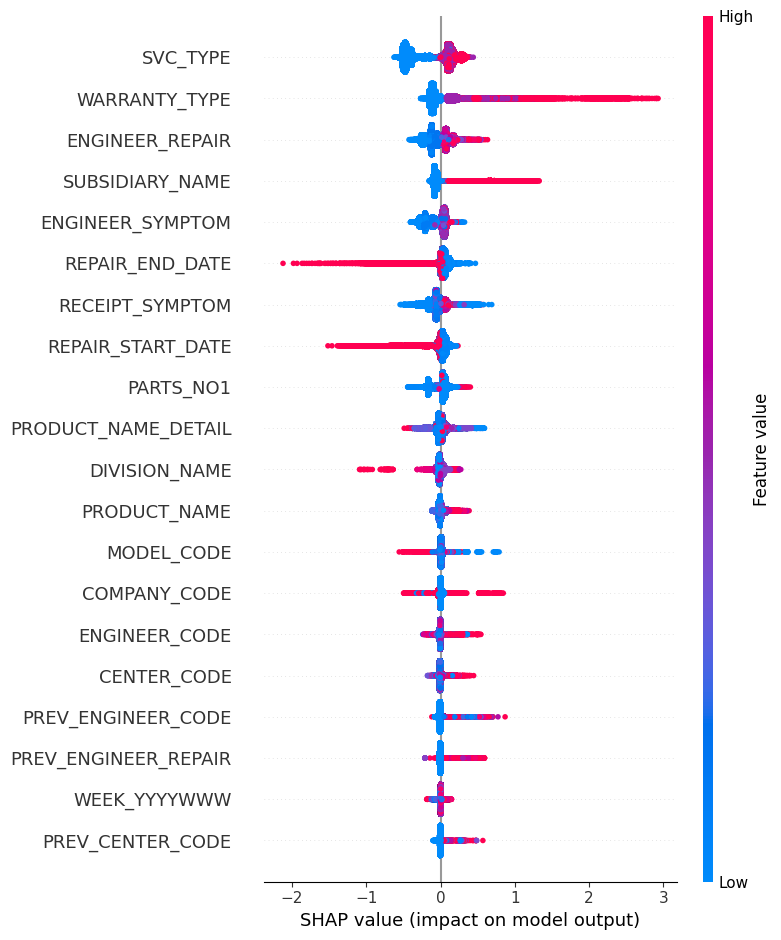

In [6]:
shap.summary_plot(shap_values, X_valid)


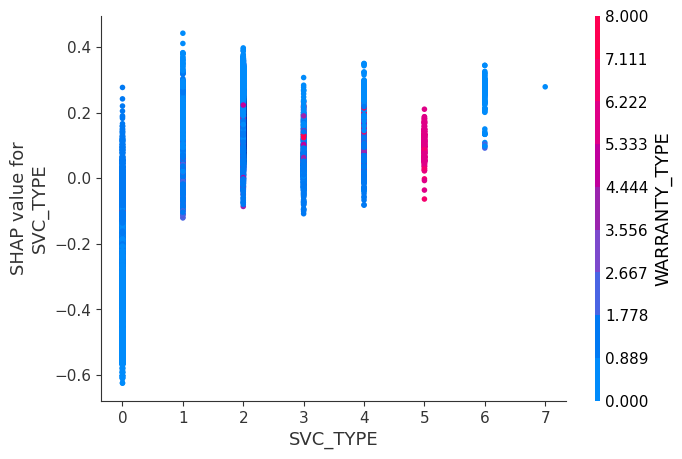

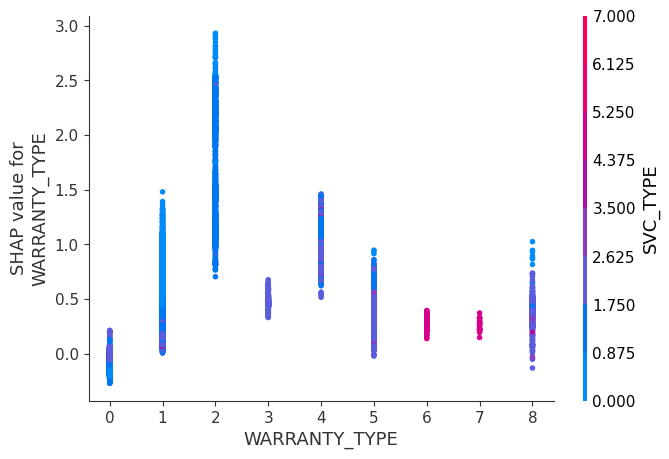

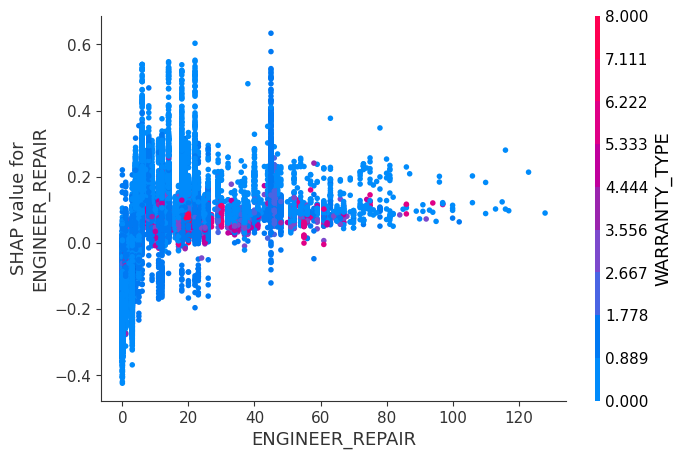

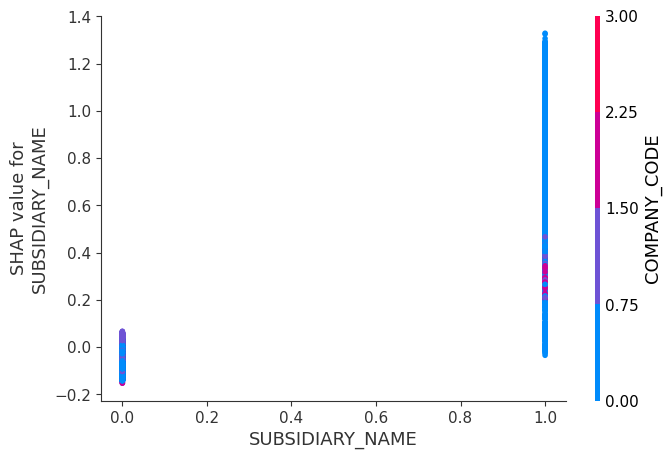

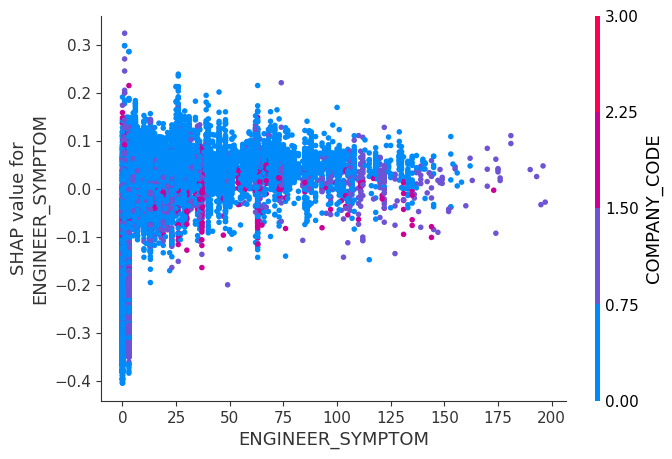

In [7]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, X_valid)


In [8]:
# get the predicted values for the validation set
y_pred = model.predict(dv)

# convert the predicted values to binary (0 or 1) based on a threshold of 0.5
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

# calculate the accuracy of the model
accuracy = sum(y_pred_binary == y_valid) / len(y_valid)
print("Accuracy:", accuracy)

# show me the correctnees by 2x2 table
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred_binary)


Accuracy: 0.9742


array([[194839,      2],
       [  5158,      1]])

In [9]:
import lightgbm as lgb

dt = lgb.Dataset(X_train, label=y_train)
dv = lgb.Dataset(X_valid, label=y_valid)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

model = lgb.train(
    params,
    dt,
    10000,
    valid_sets=[dv],
)


[1]	valid_0's binary_logloss: 0.118377
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.117277
[3]	valid_0's binary_logloss: 0.116386
[4]	valid_0's binary_logloss: 0.115623
[5]	valid_0's binary_logloss: 0.114946
[6]	valid_0's binary_logloss: 0.114359
[7]	valid_0's binary_logloss: 0.113833
[8]	valid_0's binary_logloss: 0.113366
[9]	valid_0's binary_logloss: 0.112936
[10]	valid_0's binary_logloss: 0.112519
[11]	valid_0's binary_logloss: 0.112167
[12]	valid_0's binary_logloss: 0.111843
[13]	valid_0's binary_logloss: 0.111531
[14]	valid_0's binary_logloss: 0.111265
[15]	valid_0's binary_logloss: 0.111021
[16]	valid_0's binary_logloss: 0.110805
[17]	valid_0's binary_logloss: 0.110588
[18]	valid_0's binary_logloss: 0.110409
[19]	valid_0's binary_logloss: 0.110231
[20]	valid_0's binary_logloss: 0.110083
[21]	valid_0's binary_logloss: 0.109919
[22]	valid_0's binary_logloss: 0.109778
[23]	valid_0's binary_logloss: 0.109642
[24]	valid_0's binary_loglos

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [11]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_valid.iloc[0, :])


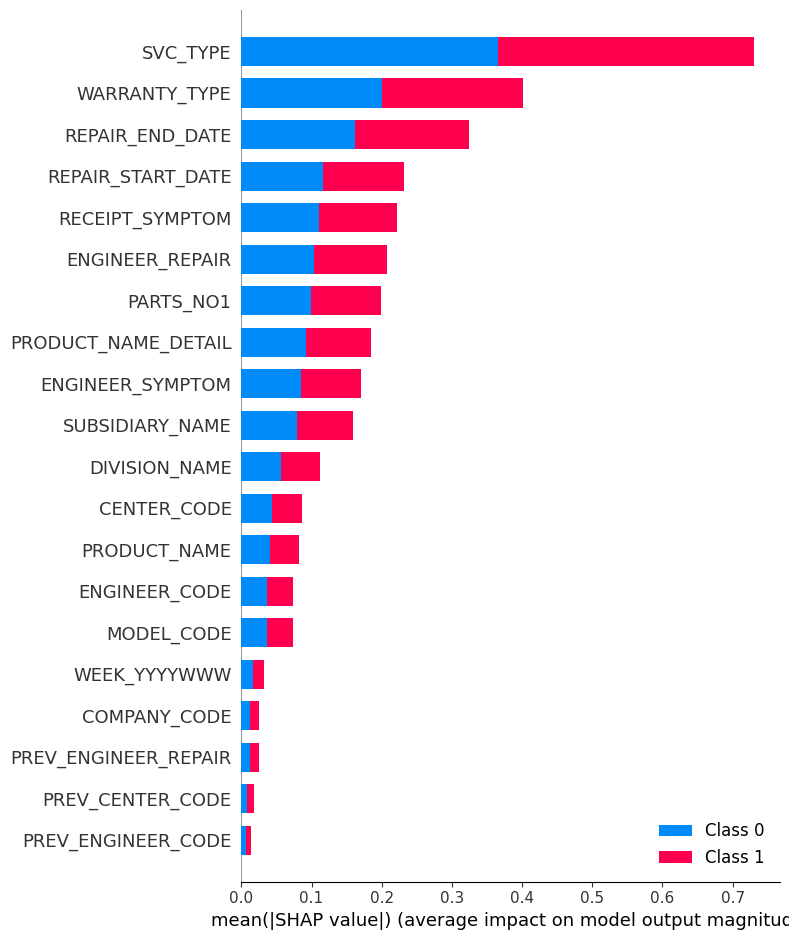

In [12]:
shap.summary_plot(shap_values, data[features])


In [13]:
# get the predicted values for the validation set
y_pred = model.predict(X_valid)

# convert the predicted values to binary (0 or 1) based on a threshold of 0.5
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

# calculate the accuracy of the model
accuracy = sum(y_pred_binary == y_valid) / len(y_valid)
print("Accuracy:", accuracy)


# show me the correctnees by 2x2 table
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred_binary)


Accuracy: 0.974205


array([[194841,      0],
       [  5159,      0]])

In [14]:
mapping['ENGINEER_REPAIR']


Index(['Demo given', 'Wet/Preventive Maintenance',
       'Part replaced-mechanical (ref#)', 'Installation of new product',
       'Internal adjustment', 'DRY SERVICE', 'External adjustment',
       'Adjustment  internal (give ref#)', 'O/W Estimate given',
       'Clean Filter',
       ...
       'Cable card malfunction', 'LED PKG Exchange',
       'Lithium Polymer cell replacem', 'NTF', 'VITM replacement',
       'HDD Failure', 'Repaired cracked PC board',
       'Refitting, put back in position', 'Product upgrade (on request)',
       'Component video not operating'],
      dtype='object', length=132)

In [18]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

tabnet_model = TabNetClassifier()
tabnet_model.fit(X_train.values, y_train.values, eval_set=[(X_valid.values, y_valid.values)], patience=10, max_epochs=20)


Device used : cuda


epoch 0  | loss: 0.11781 | val_0_auc: 0.70262 |  0:00:33s
epoch 1  | loss: 0.11274 | val_0_auc: 0.72715 |  0:01:04s
epoch 2  | loss: 0.11196 | val_0_auc: 0.73605 |  0:01:36s
epoch 3  | loss: 0.11128 | val_0_auc: 0.73863 |  0:02:09s
epoch 4  | loss: 0.11075 | val_0_auc: 0.74085 |  0:02:40s
epoch 5  | loss: 0.11068 | val_0_auc: 0.74376 |  0:03:11s
epoch 6  | loss: 0.11071 | val_0_auc: 0.73927 |  0:03:39s
epoch 7  | loss: 0.11069 | val_0_auc: 0.73831 |  0:04:09s
epoch 8  | loss: 0.11063 | val_0_auc: 0.73904 |  0:04:40s
epoch 9  | loss: 0.11085 | val_0_auc: 0.73912 |  0:05:10s
epoch 10 | loss: 0.11109 | val_0_auc: 0.73591 |  0:05:40s
epoch 11 | loss: 0.11057 | val_0_auc: 0.7425  |  0:06:11s
epoch 12 | loss: 0.11022 | val_0_auc: 0.73819 |  0:06:41s
epoch 13 | loss: 0.11062 | val_0_auc: 0.74043 |  0:07:11s
epoch 14 | loss: 0.11029 | val_0_auc: 0.74675 |  0:07:40s
epoch 15 | loss: 0.10999 | val_0_auc: 0.74744 |  0:08:09s
epoch 16 | loss: 0.10982 | val_0_auc: 0.74405 |  0:08:38s
epoch 17 | los

Best weights from best epoch are automatically used!


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=56, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

In [19]:
def tabnet_predict(data):
    return tabnet_model.predict_proba(data)[:, 1]  # Modify this according to your model's output


Permutation explainer: 1001it [08:01,  2.03it/s]                          
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


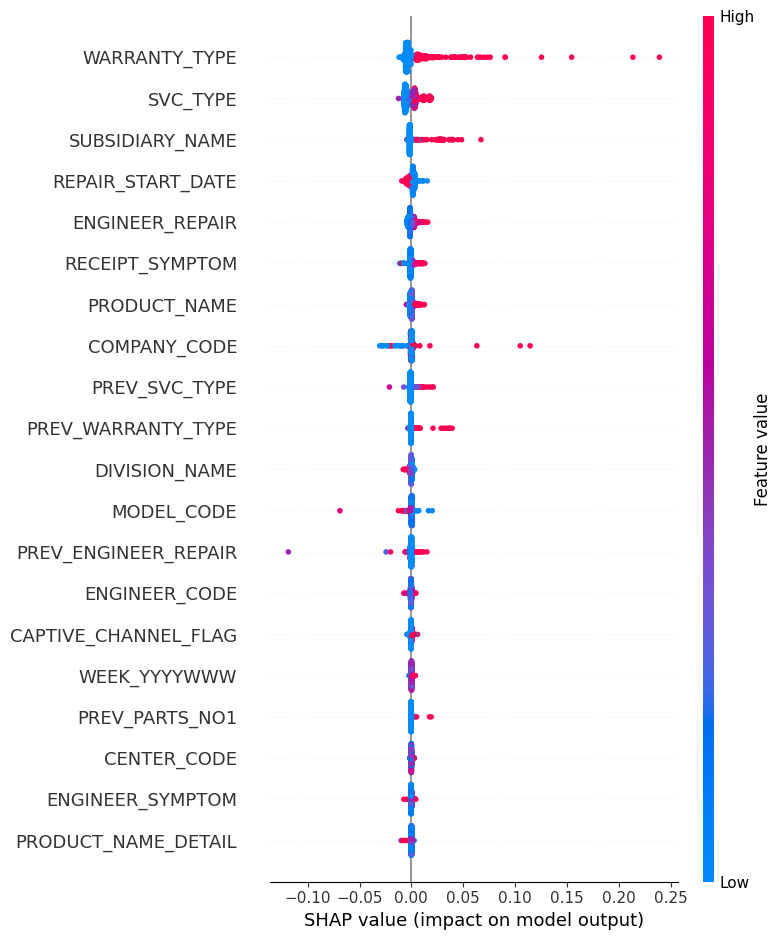

In [32]:
# Explain the model predictions using SHAP
x_valid_sample = X_valid.sample(1000)

tabnet_explainer = shap.Explainer(tabnet_predict, X_train.values)
tabnet_shap_values = tabnet_explainer(x_valid_sample.values)

# Plot the SHAP values
shap.summary_plot(tabnet_shap_values, x_valid_sample, feature_names=X_valid.columns)


In [33]:
# confusion matrix for tabnet
y_pred = tabnet_model.predict(X_valid.values)
accuracy = sum(y_pred == y_valid) / len(y_valid)
print("Accuracy:", accuracy)
confusion_matrix(y_valid, y_pred)


Accuracy: 0.974205


array([[194841,      0],
       [  5159,      0]])

In [34]:
display(mapping['SVC_TYPE'])
display(mapping['WARRANTY_TYPE'])
display(mapping['ENGINEER_REPAIR'])
display(mapping['ENGINEER_SYMPTOM'])


Index(['IS', 'MS', 'IH', 'CI', 'PD', 'CD', 'DI', 'ID'], dtype='object')

Index(['IW', 'OW', 'P', 'EP', 'EW', 'OZ', 'IG', 'OG', 'EM', '<NULL>'], dtype='object')

Index(['Demo given', 'Wet/Preventive Maintenance',
       'Part replaced-mechanical (ref#)', 'Installation of new product',
       'Internal adjustment', 'DRY SERVICE', 'External adjustment',
       'Adjustment  internal (give ref#)', 'O/W Estimate given',
       'Clean Filter',
       ...
       'Cable card malfunction', 'LED PKG Exchange',
       'Lithium Polymer cell replacem', 'NTF', 'VITM replacement',
       'HDD Failure', 'Repaired cracked PC board',
       'Refitting, put back in position', 'Product upgrade (on request)',
       'Component video not operating'],
      dtype='object', length=132)

Index(['Demo', 'Free Service', 'Intermittent mech noise or vibration',
       'Installation of a Product', 'Adjustment due to Insect / Animal / Rat',
       'Regular Maintenance visit / Filter Cleaning',
       'Special feature/operation does not work',
       'Payment Recieved from customer',
       'Drain System choke / PV Assy water leakage',
       'Dry Service / Filter Clean',
       ...
       'Reassembly (CONNECTOR, HOUSING)', 'Warp/Deformation',
       'FF/RWD/Search malfunction', 'Confirm Customer Inquiry',
       'Intermittent battery problem', 'Skipping during playback',
       'No playback-audio (video OK)', 'Black circles on panel',
       'No on-screen display', 'Pixelating image while tuning'],
      dtype='object', length=207)